APPROACH THAT WE USED IN THIS RESEARCH

In [1]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

In [2]:
train_dir = "../data/final/train"
test_dir  = "../data/final/test"

img_size = (224, 224)
batch_size = 16

image_files = [f for f in os.listdir(train_dir) if f.endswith(".tif")]


class_labels = sorted(set(f.split("_")[0] for f in image_files))
class_to_index = {label: i for i, label in enumerate(class_labels)}

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='sparse', color_mode='rgb'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=False  
)

Found 9252 images belonging to 257 classes.
Found 514 images belonging to 257 classes.


In [3]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:-16]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
predictions = Dense(train_gen.num_classes, activation='softmax', 
                    kernel_regularizer=regularizers.l2(0.001))(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-7)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,                 
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_fingerprint_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=100,
    callbacks=[lr_scheduler, early_stopping, checkpoint]
)

model.save("best_fingerprint_model.h5")
print("\nModel trained and saved as best_fingerprint_model.h5")

Epoch 1/100
579/579 [==============================] - ETA: 0s - loss: 7.1367 - accuracy: 0.0069
Epoch 1: val_accuracy improved from -inf to 0.01751, saving model to best_fingerprint_model.h5
579/579 [==============================] - 124s 191ms/step - loss: 7.1367 - accuracy: 0.0069 - val_loss: 6.9186 - val_accuracy: 0.0175 - lr: 1.0000e-05
Epoch 2/100
579/579 [==============================] - ETA: 0s - loss: 6.6197 - accuracy: 0.0385
Epoch 2: val_accuracy improved from 0.01751 to 0.10700, saving model to best_fingerprint_model.h5
579/579 [==============================] - 118s 204ms/step - loss: 6.6197 - accuracy: 0.0385 - val_loss: 6.2001 - val_accuracy: 0.1070 - lr: 1.0000e-05
Epoch 3/100
579/579 [==============================] - ETA: 0s - loss: 5.8123 - accuracy: 0.1113
Epoch 3: val_accuracy improved from 0.10700 to 0.21790, saving model to best_fingerprint_model.h5
579/579 [==============================] - 140s 241ms/step - loss: 5.8123 - accuracy: 0.1113 - val_loss: 5.4175 - 

In [4]:
print(test_gen.class_indices)

{'001_1': 0, '001_2': 1, '001_3': 2, '001_4': 3, '001_5': 4, '001_6': 5, '002_10': 6, '002_11': 7, '002_12': 8, '002_7': 9, '002_8': 10, '002_9': 11, '003_13': 12, '003_14': 13, '003_15': 14, '003_16': 15, '003_17': 16, '003_18': 17, '004_19': 18, '004_20': 19, '004_21': 20, '004_22': 21, '004_23': 22, '004_24': 23, '005_25': 24, '005_26': 25, '005_27': 26, '005_28': 27, '005_29': 28, '005_30': 29, '006_31': 30, '006_32': 31, '006_33': 32, '006_34': 33, '006_35': 34, '006_36': 35, '007_37': 36, '007_38': 37, '007_39': 38, '007_40': 39, '007_41': 40, '007_42': 41, '008_43': 42, '008_44': 43, '008_45': 44, '009_46': 45, '009_47': 46, '009_48': 47, '009_49': 48, '009_50': 49, '009_51': 50, '010_52': 51, '010_53': 52, '010_54': 53, '010_55': 54, '010_56': 55, '010_57': 56, '010_58': 57, '010_59': 58, '010_60': 59, '010_61': 60, '011_62': 61, '011_63': 62, '011_64': 63, '011_65': 64, '011_66': 65, '011_67': 66, '011_68': 67, '011_69': 68, '011_70': 69, '011_71': 70, '012_72': 71, '012_73': 

In [ ]:
Epoch 1/100
579/579 [==============================] - ETA: 0s - loss: 7.1367 - accuracy: 0.0069
Epoch 1: val_accuracy improved from -inf to 0.01751, saving model to best_fingerprint_model.h5
579/579 [==============================] - 124s 191ms/step - loss: 7.1367 - accuracy: 0.0069 - val_loss: 6.9186 - val_accuracy: 0.0175 - lr: 1.0000e-05
Epoch 2/100
579/579 [==============================] - ETA: 0s - loss: 6.6197 - accuracy: 0.0385
Epoch 2: val_accuracy improved from 0.01751 to 0.10700, saving model to best_fingerprint_model.h5
579/579 [==============================] - 118s 204ms/step - loss: 6.6197 - accuracy: 0.0385 - val_loss: 6.2001 - val_accuracy: 0.1070 - lr: 1.0000e-05
Epoch 3/100
579/579 [==============================] - ETA: 0s - loss: 5.8123 - accuracy: 0.1113
Epoch 3: val_accuracy improved from 0.10700 to 0.21790, saving model to best_fingerprint_model.h5
579/579 [==============================] - 140s 241ms/step - loss: 5.8123 - accuracy: 0.1113 - val_loss: 5.4175 - val_accuracy: 0.2179 - lr: 1.0000e-05
Epoch 4/100
579/579 [==============================] - ETA: 0s - loss: 4.9656 - accuracy: 0.2298
Epoch 4: val_accuracy improved from 0.21790 to 0.28988, saving model to best_fingerprint_model.h5
579/579 [==============================] - 139s 240ms/step - loss: 4.9656 - accuracy: 0.2298 - val_loss: 4.9436 - val_accuracy: 0.2899 - lr: 1.0000e-05
Epoch 5/100
579/579 [==============================] - ETA: 0s - loss: 4.2380 - accuracy: 0.3430
Epoch 5: val_accuracy improved from 0.28988 to 0.42607, saving model to best_fingerprint_model.h5
579/579 [==============================] - 139s 240ms/step - loss: 4.2380 - accuracy: 0.3430 - val_loss: 4.1651 - val_accuracy: 0.4261 - lr: 1.0000e-05
Epoch 6/100
579/579 [==============================] - ETA: 0s - loss: 3.6190 - accuracy: 0.4610
Epoch 6: val_accuracy improved from 0.42607 to 0.46498, saving model to best_fingerprint_model.h5
579/579 [==============================] - 139s 239ms/step - loss: 3.6190 - accuracy: 0.4610 - val_loss: 3.8966 - val_accuracy: 0.4650 - lr: 1.0000e-05
Epoch 7/100
579/579 [==============================] - ETA: 0s - loss: 3.1714 - accuracy: 0.5524
Epoch 7: val_accuracy improved from 0.46498 to 0.58560, saving model to best_fingerprint_model.h5
579/579 [==============================] - 139s 239ms/step - loss: 3.1714 - accuracy: 0.5524 - val_loss: 3.2756 - val_accuracy: 0.5856 - lr: 1.0000e-05
Epoch 8/100
579/579 [==============================] - ETA: 0s - loss: 2.8100 - accuracy: 0.6296
Epoch 8: val_accuracy improved from 0.58560 to 0.62451, saving model to best_fingerprint_model.h5
579/579 [==============================] - 139s 240ms/step - loss: 2.8100 - accuracy: 0.6296 - val_loss: 3.0003 - val_accuracy: 0.6245 - lr: 1.0000e-05
Epoch 9/100
579/579 [==============================] - ETA: 0s - loss: 2.5501 - accuracy: 0.6950
Epoch 9: val_accuracy did not improve from 0.62451
579/579 [==============================] - 138s 239ms/step - loss: 2.5501 - accuracy: 0.6950 - val_loss: 3.1941 - val_accuracy: 0.5661 - lr: 1.0000e-05
Epoch 10/100
579/579 [==============================] - ETA: 0s - loss: 2.3544 - accuracy: 0.7420
Epoch 10: val_accuracy did not improve from 0.62451
579/579 [==============================] - 139s 239ms/step - loss: 2.3544 - accuracy: 0.7420 - val_loss: 2.9632 - val_accuracy: 0.5992 - lr: 1.0000e-05
Epoch 11/100
579/579 [==============================] - ETA: 0s - loss: 2.2039 - accuracy: 0.7724
Epoch 11: val_accuracy improved from 0.62451 to 0.67121, saving model to best_fingerprint_model.h5
579/579 [==============================] - 139s 241ms/step - loss: 2.2039 - accuracy: 0.7724 - val_loss: 2.6869 - val_accuracy: 0.6712 - lr: 1.0000e-05
Epoch 12/100
579/579 [==============================] - ETA: 0s - loss: 2.0542 - accuracy: 0.8134
Epoch 12: val_accuracy did not improve from 0.67121
579/579 [==============================] - 139s 240ms/step - loss: 2.0542 - accuracy: 0.8134 - val_loss: 2.7720 - val_accuracy: 0.6634 - lr: 1.0000e-05
Epoch 13/100
579/579 [==============================] - ETA: 0s - loss: 1.9692 - accuracy: 0.8390
Epoch 13: val_accuracy improved from 0.67121 to 0.68872, saving model to best_fingerprint_model.h5
579/579 [==============================] - 140s 241ms/step - loss: 1.9692 - accuracy: 0.8390 - val_loss: 2.5872 - val_accuracy: 0.6887 - lr: 1.0000e-05
Epoch 14/100
579/579 [==============================] - ETA: 0s - loss: 1.8936 - accuracy: 0.8597
Epoch 14: val_accuracy did not improve from 0.68872
579/579 [==============================] - 139s 240ms/step - loss: 1.8936 - accuracy: 0.8597 - val_loss: 2.6123 - val_accuracy: 0.6848 - lr: 1.0000e-05
Epoch 15/100
579/579 [==============================] - ETA: 0s - loss: 1.8067 - accuracy: 0.8812
Epoch 15: val_accuracy did not improve from 0.68872
579/579 [==============================] - 139s 239ms/step - loss: 1.8067 - accuracy: 0.8812 - val_loss: 2.6518 - val_accuracy: 0.6673 - lr: 1.0000e-05
Epoch 16/100
579/579 [==============================] - ETA: 0s - loss: 1.7806 - accuracy: 0.8902
Epoch 16: val_accuracy improved from 0.68872 to 0.70233, saving model to best_fingerprint_model.h5
579/579 [==============================] - 139s 241ms/step - loss: 1.7806 - accuracy: 0.8902 - val_loss: 2.5259 - val_accuracy: 0.7023 - lr: 1.0000e-05
Epoch 17/100
579/579 [==============================] - ETA: 0s - loss: 1.7276 - accuracy: 0.9026
Epoch 17: val_accuracy improved from 0.70233 to 0.71206, saving model to best_fingerprint_model.h5
579/579 [==============================] - 139s 240ms/step - loss: 1.7276 - accuracy: 0.9026 - val_loss: 2.4191 - val_accuracy: 0.7121 - lr: 1.0000e-05
Epoch 18/100
579/579 [==============================] - ETA: 0s - loss: 1.6998 - accuracy: 0.9090
Epoch 18: val_accuracy did not improve from 0.71206
579/579 [==============================] - 139s 240ms/step - loss: 1.6998 - accuracy: 0.9090 - val_loss: 2.5300 - val_accuracy: 0.6984 - lr: 1.0000e-05
Epoch 19/100
579/579 [==============================] - ETA: 0s - loss: 1.6459 - accuracy: 0.9229
Epoch 19: val_accuracy improved from 0.71206 to 0.72374, saving model to best_fingerprint_model.h5
579/579 [==============================] - 139s 240ms/step - loss: 1.6459 - accuracy: 0.9229 - val_loss: 2.4968 - val_accuracy: 0.7237 - lr: 1.0000e-05
Epoch 20/100
579/579 [==============================] - ETA: 0s - loss: 1.6306 - accuracy: 0.9329
Epoch 20: val_accuracy improved from 0.72374 to 0.76070, saving model to best_fingerprint_model.h5
579/579 [==============================] - 139s 240ms/step - loss: 1.6306 - accuracy: 0.9329 - val_loss: 2.3029 - val_accuracy: 0.7607 - lr: 1.0000e-05
Epoch 21/100
579/579 [==============================] - ETA: 0s - loss: 1.5990 - accuracy: 0.9384
Epoch 21: val_accuracy did not improve from 0.76070
579/579 [==============================] - 138s 239ms/step - loss: 1.5990 - accuracy: 0.9384 - val_loss: 2.4209 - val_accuracy: 0.7121 - lr: 1.0000e-05
Epoch 22/100
579/579 [==============================] - ETA: 0s - loss: 1.5788 - accuracy: 0.9440
Epoch 22: val_accuracy improved from 0.76070 to 0.77432, saving model to best_fingerprint_model.h5
579/579 [==============================] - 139s 239ms/step - loss: 1.5788 - accuracy: 0.9440 - val_loss: 2.2647 - val_accuracy: 0.7743 - lr: 1.0000e-05
Epoch 23/100
579/579 [==============================] - ETA: 0s - loss: 1.5757 - accuracy: 0.9424
Epoch 23: val_accuracy did not improve from 0.77432
579/579 [==============================] - 139s 239ms/step - loss: 1.5757 - accuracy: 0.9424 - val_loss: 2.3204 - val_accuracy: 0.7451 - lr: 1.0000e-05
Epoch 24/100
579/579 [==============================] - ETA: 0s - loss: 1.5440 - accuracy: 0.9497
Epoch 24: val_accuracy did not improve from 0.77432
579/579 [==============================] - 139s 240ms/step - loss: 1.5440 - accuracy: 0.9497 - val_loss: 2.4217 - val_accuracy: 0.7257 - lr: 1.0000e-05
Epoch 25/100
579/579 [==============================] - ETA: 0s - loss: 1.5324 - accuracy: 0.9546
Epoch 25: val_accuracy did not improve from 0.77432
579/579 [==============================] - 138s 239ms/step - loss: 1.5324 - accuracy: 0.9546 - val_loss: 2.6034 - val_accuracy: 0.7004 - lr: 1.0000e-05
Epoch 26/100
579/579 [==============================] - ETA: 0s - loss: 1.4561 - accuracy: 0.9752
Epoch 26: val_accuracy improved from 0.77432 to 0.77821, saving model to best_fingerprint_model.h5
579/579 [==============================] - 138s 239ms/step - loss: 1.4561 - accuracy: 0.9752 - val_loss: 2.2131 - val_accuracy: 0.7782 - lr: 5.0000e-06
Epoch 27/100
579/579 [==============================] - ETA: 0s - loss: 1.4452 - accuracy: 0.9778
Epoch 27: val_accuracy improved from 0.77821 to 0.78988, saving model to best_fingerprint_model.h5
579/579 [==============================] - 138s 238ms/step - loss: 1.4452 - accuracy: 0.9778 - val_loss: 2.1977 - val_accuracy: 0.7899 - lr: 5.0000e-06
Epoch 28/100
579/579 [==============================] - ETA: 0s - loss: 1.4436 - accuracy: 0.9789
Epoch 28: val_accuracy did not improve from 0.78988
579/579 [==============================] - 139s 240ms/step - loss: 1.4436 - accuracy: 0.9789 - val_loss: 2.3329 - val_accuracy: 0.7412 - lr: 5.0000e-06
Epoch 29/100
579/579 [==============================] - ETA: 0s - loss: 1.4397 - accuracy: 0.9776
Epoch 29: val_accuracy did not improve from 0.78988
579/579 [==============================] - 139s 240ms/step - loss: 1.4397 - accuracy: 0.9776 - val_loss: 2.3260 - val_accuracy: 0.7354 - lr: 5.0000e-06
Epoch 30/100
579/579 [==============================] - ETA: 0s - loss: 1.4307 - accuracy: 0.9802
Epoch 30: val_accuracy improved from 0.78988 to 0.80545, saving model to best_fingerprint_model.h5
579/579 [==============================] - 139s 240ms/step - loss: 1.4307 - accuracy: 0.9802 - val_loss: 2.1424 - val_accuracy: 0.8054 - lr: 5.0000e-06
Epoch 31/100
579/579 [==============================] - ETA: 0s - loss: 1.4314 - accuracy: 0.9795
Epoch 31: val_accuracy did not improve from 0.80545
579/579 [==============================] - 139s 240ms/step - loss: 1.4314 - accuracy: 0.9795 - val_loss: 2.2483 - val_accuracy: 0.7665 - lr: 5.0000e-06
Epoch 32/100
579/579 [==============================] - ETA: 0s - loss: 1.4198 - accuracy: 0.9826
Epoch 32: val_accuracy did not improve from 0.80545
579/579 [==============================] - 139s 241ms/step - loss: 1.4198 - accuracy: 0.9826 - val_loss: 2.4926 - val_accuracy: 0.7023 - lr: 5.0000e-06
Epoch 33/100
579/579 [==============================] - ETA: 0s - loss: 1.4194 - accuracy: 0.9807
Epoch 33: val_accuracy did not improve from 0.80545
579/579 [==============================] - 140s 241ms/step - loss: 1.4194 - accuracy: 0.9807 - val_loss: 2.1588 - val_accuracy: 0.7860 - lr: 5.0000e-06
Epoch 34/100
579/579 [==============================] - ETA: 0s - loss: 1.3921 - accuracy: 0.9892
Epoch 34: val_accuracy did not improve from 0.80545
579/579 [==============================] - 140s 242ms/step - loss: 1.3921 - accuracy: 0.9892 - val_loss: 2.1541 - val_accuracy: 0.7860 - lr: 2.5000e-06
Epoch 35/100
579/579 [==============================] - ETA: 0s - loss: 1.3893 - accuracy: 0.9888
Epoch 35: val_accuracy did not improve from 0.80545
579/579 [==============================] - 140s 242ms/step - loss: 1.3893 - accuracy: 0.9888 - val_loss: 2.3284 - val_accuracy: 0.7490 - lr: 2.5000e-06
Epoch 36/100
579/579 [==============================] - ETA: 0s - loss: 1.3823 - accuracy: 0.9901
Epoch 36: val_accuracy did not improve from 0.80545
579/579 [==============================] - 140s 242ms/step - loss: 1.3823 - accuracy: 0.9901 - val_loss: 2.2361 - val_accuracy: 0.7782 - lr: 2.5000e-06
Epoch 37/100
579/579 [==============================] - ETA: 0s - loss: 1.3745 - accuracy: 0.9909
Epoch 37: val_accuracy improved from 0.80545 to 0.80934, saving model to best_fingerprint_model.h5
579/579 [==============================] - 141s 243ms/step - loss: 1.3745 - accuracy: 0.9909 - val_loss: 2.1069 - val_accuracy: 0.8093 - lr: 1.2500e-06
Epoch 38/100
579/579 [==============================] - ETA: 0s - loss: 1.3734 - accuracy: 0.9922
Epoch 38: val_accuracy did not improve from 0.80934
579/579 [==============================] - 140s 242ms/step - loss: 1.3734 - accuracy: 0.9922 - val_loss: 2.1083 - val_accuracy: 0.8054 - lr: 1.2500e-06
Epoch 39/100
579/579 [==============================] - ETA: 0s - loss: 1.3643 - accuracy: 0.9944
Epoch 39: val_accuracy did not improve from 0.80934
579/579 [==============================] - 140s 242ms/step - loss: 1.3643 - accuracy: 0.9944 - val_loss: 2.2965 - val_accuracy: 0.7763 - lr: 1.2500e-06
Epoch 40/100
579/579 [==============================] - ETA: 0s - loss: 1.3653 - accuracy: 0.9939
Epoch 40: val_accuracy did not improve from 0.80934
579/579 [==============================] - 141s 243ms/step - loss: 1.3653 - accuracy: 0.9939 - val_loss: 2.2370 - val_accuracy: 0.7840 - lr: 1.2500e-06
Epoch 41/100
579/579 [==============================] - ETA: 0s - loss: 1.3622 - accuracy: 0.9942
Epoch 41: val_accuracy did not improve from 0.80934
579/579 [==============================] - 139s 240ms/step - loss: 1.3622 - accuracy: 0.9942 - val_loss: 2.1483 - val_accuracy: 0.8093 - lr: 6.2500e-07
Epoch 42/100
579/579 [==============================] - ETA: 0s - loss: 1.3606 - accuracy: 0.9947
Epoch 42: val_accuracy did not improve from 0.80934
579/579 [==============================] - 139s 240ms/step - loss: 1.3606 - accuracy: 0.9947 - val_loss: 2.1783 - val_accuracy: 0.8054 - lr: 6.2500e-07
Epoch 43/100
579/579 [==============================] - ETA: 0s - loss: 1.3576 - accuracy: 0.9951
Epoch 43: val_accuracy did not improve from 0.80934
579/579 [==============================] - 139s 240ms/step - loss: 1.3576 - accuracy: 0.9951 - val_loss: 2.1792 - val_accuracy: 0.8074 - lr: 6.2500e-07
Epoch 44/100
579/579 [==============================] - ETA: 0s - loss: 1.3567 - accuracy: 0.9956
Epoch 44: val_accuracy did not improve from 0.80934
579/579 [==============================] - 139s 240ms/step - loss: 1.3567 - accuracy: 0.9956 - val_loss: 2.1735 - val_accuracy: 0.8074 - lr: 3.1250e-07
Epoch 45/100
579/579 [==============================] - ETA: 0s - loss: 1.3544 - accuracy: 0.9951
Epoch 45: val_accuracy did not improve from 0.80934
579/579 [==============================] - 139s 239ms/step - loss: 1.3544 - accuracy: 0.9951 - val_loss: 2.1503 - val_accuracy: 0.8016 - lr: 3.1250e-07
Epoch 46/100
579/579 [==============================] - ETA: 0s - loss: 1.3606 - accuracy: 0.9932
Epoch 46: val_accuracy improved from 0.80934 to 0.81323, saving model to best_fingerprint_model.h5
579/579 [==============================] - 138s 239ms/step - loss: 1.3606 - accuracy: 0.9932 - val_loss: 2.0722 - val_accuracy: 0.8132 - lr: 3.1250e-07
Epoch 47/100
579/579 [==============================] - ETA: 0s - loss: 1.3536 - accuracy: 0.9951
Epoch 47: val_accuracy did not improve from 0.81323
579/579 [==============================] - 138s 238ms/step - loss: 1.3536 - accuracy: 0.9951 - val_loss: 2.1255 - val_accuracy: 0.7996 - lr: 3.1250e-07
Epoch 48/100
579/579 [==============================] - ETA: 0s - loss: 1.3523 - accuracy: 0.9959
Epoch 48: val_accuracy did not improve from 0.81323
579/579 [==============================] - 138s 238ms/step - loss: 1.3523 - accuracy: 0.9959 - val_loss: 2.1633 - val_accuracy: 0.8035 - lr: 3.1250e-07
Epoch 49/100
579/579 [==============================] - ETA: 0s - loss: 1.3532 - accuracy: 0.9951
Epoch 49: val_accuracy improved from 0.81323 to 0.81518, saving model to best_fingerprint_model.h5
579/579 [==============================] - 138s 238ms/step - loss: 1.3532 - accuracy: 0.9951 - val_loss: 2.0895 - val_accuracy: 0.8152 - lr: 3.1250e-07
Epoch 50/100
579/579 [==============================] - ETA: 0s - loss: 1.3515 - accuracy: 0.9948
Epoch 50: val_accuracy did not improve from 0.81518
579/579 [==============================] - 139s 240ms/step - loss: 1.3515 - accuracy: 0.9948 - val_loss: 2.0920 - val_accuracy: 0.8093 - lr: 1.5625e-07
Epoch 51/100
579/579 [==============================] - ETA: 0s - loss: 1.3540 - accuracy: 0.9946
Epoch 51: val_accuracy did not improve from 0.81518
579/579 [==============================] - 139s 240ms/step - loss: 1.3540 - accuracy: 0.9946 - val_loss: 2.1183 - val_accuracy: 0.8152 - lr: 1.5625e-07
Epoch 52/100
579/579 [==============================] - ETA: 0s - loss: 1.3519 - accuracy: 0.9948
Epoch 52: val_accuracy did not improve from 0.81518
579/579 [==============================] - 139s 240ms/step - loss: 1.3519 - accuracy: 0.9948 - val_loss: 2.0749 - val_accuracy: 0.8152 - lr: 1.5625e-07
Epoch 53/100
579/579 [==============================] - ETA: 0s - loss: 1.3493 - accuracy: 0.9968
Epoch 53: val_accuracy did not improve from 0.81518
579/579 [==============================] - 139s 240ms/step - loss: 1.3493 - accuracy: 0.9968 - val_loss: 2.0992 - val_accuracy: 0.8074 - lr: 1.0000e-07
Epoch 54/100
579/579 [==============================] - ETA: 0s - loss: 1.3478 - accuracy: 0.9964
Epoch 54: val_accuracy improved from 0.81518 to 0.82296, saving model to best_fingerprint_model.h5
579/579 [==============================] - 139s 240ms/step - loss: 1.3478 - accuracy: 0.9964 - val_loss: 2.0637 - val_accuracy: 0.8230 - lr: 1.0000e-07
Epoch 55/100
579/579 [==============================] - ETA: 0s - loss: 1.3514 - accuracy: 0.9956
Epoch 55: val_accuracy did not improve from 0.82296
579/579 [==============================] - 139s 240ms/step - loss: 1.3514 - accuracy: 0.9956 - val_loss: 2.0968 - val_accuracy: 0.8132 - lr: 1.0000e-07
Epoch 56/100
579/579 [==============================] - ETA: 0s - loss: 1.3525 - accuracy: 0.9942
Epoch 56: val_accuracy did not improve from 0.82296
579/579 [==============================] - 139s 240ms/step - loss: 1.3525 - accuracy: 0.9942 - val_loss: 2.0875 - val_accuracy: 0.8093 - lr: 1.0000e-07
Epoch 57/100
579/579 [==============================] - ETA: 0s - loss: 1.3488 - accuracy: 0.9962
Epoch 57: val_accuracy did not improve from 0.82296
579/579 [==============================] - 139s 240ms/step - loss: 1.3488 - accuracy: 0.9962 - val_loss: 2.0778 - val_accuracy: 0.8191 - lr: 1.0000e-07
Epoch 58/100
579/579 [==============================] - ETA: 0s - loss: 1.3479 - accuracy: 0.9968
Epoch 58: val_accuracy did not improve from 0.82296
579/579 [==============================] - 139s 241ms/step - loss: 1.3479 - accuracy: 0.9968 - val_loss: 2.0848 - val_accuracy: 0.8191 - lr: 1.0000e-07
Epoch 59/100
579/579 [==============================] - ETA: 0s - loss: 1.3504 - accuracy: 0.9949
Epoch 59: val_accuracy did not improve from 0.82296
579/579 [==============================] - 139s 240ms/step - loss: 1.3504 - accuracy: 0.9949 - val_loss: 2.0809 - val_accuracy: 0.8132 - lr: 1.0000e-07
Epoch 60/100
579/579 [==============================] - ETA: 0s - loss: 1.3470 - accuracy: 0.9964
Epoch 60: val_accuracy did not improve from 0.82296
579/579 [==============================] - 139s 240ms/step - loss: 1.3470 - accuracy: 0.9964 - val_loss: 2.0915 - val_accuracy: 0.8113 - lr: 1.0000e-07
Epoch 61/100
579/579 [==============================] - ETA: 0s - loss: 1.3470 - accuracy: 0.9964
Epoch 61: val_accuracy did not improve from 0.82296
579/579 [==============================] - 139s 240ms/step - loss: 1.3470 - accuracy: 0.9964 - val_loss: 2.0832 - val_accuracy: 0.8171 - lr: 1.0000e-07
Epoch 62/100
579/579 [==============================] - ETA: 0s - loss: 1.3486 - accuracy: 0.9963
Epoch 62: val_accuracy did not improve from 0.82296
579/579 [==============================] - 139s 240ms/step - loss: 1.3486 - accuracy: 0.9963 - val_loss: 2.0857 - val_accuracy: 0.8152 - lr: 1.0000e-07
Epoch 63/100
579/579 [==============================] - ETA: 0s - loss: 1.3454 - accuracy: 0.9970
Epoch 63: val_accuracy did not improve from 0.82296
579/579 [==============================] - 139s 240ms/step - loss: 1.3454 - accuracy: 0.9970 - val_loss: 2.1240 - val_accuracy: 0.8074 - lr: 1.0000e-07
Epoch 64/100
579/579 [==============================] - ETA: 0s - loss: 1.3484 - accuracy: 0.9959Restoring model weights from the end of the best epoch: 54.

Epoch 64: val_accuracy did not improve from 0.82296
579/579 [==============================] - 139s 240ms/step - loss: 1.3484 - accuracy: 0.9959 - val_loss: 2.1301 - val_accuracy: 0.8054 - lr: 1.0000e-07
Epoch 64: early stopping

Model trained and saved as best_fingerprint_model.h5

In [5]:
model = load_model("best_fingerprint_model.h5")

loss, accuracy = model.evaluate(test_gen)
print(f"\n Test Loss: {loss:.4f}")
print(f" Test Accuracy: {accuracy:.4f}")

33/33 [==============================] - 3s 80ms/step - loss: 2.0637 - accuracy: 0.8230

 Test Loss: 2.0637
 Test Accuracy: 0.8230


In [6]:
X_test = []
y_test = []

steps = int(np.ceil(test_gen.samples / test_gen.batch_size))

for i in range(steps):
    x, y = next(test_gen)
    X_test.append(x)
    y_test.append(y)

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

y_pred_probs = model.predict(X_test, batch_size=16)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

33/33 [==============================] - 3s 78ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0     0.6667    1.0000    0.8000         2
         1.0     1.0000    1.0000    1.0000         2
         2.0     1.0000    1.0000    1.0000         2
         3.0     1.0000    1.0000    1.0000         2
         4.0     1.0000    0.5000    0.6667         2
         5.0     1.0000    0.5000    0.6667         2
         6.0     0.6667    1.0000    0.8000         2
         7.0     1.0000    1.0000    1.0000         2
         8.0     1.0000    1.0000    1.0000         2
         9.0     1.0000    1.0000    1.0000         2
        10.0     0.5000    0.5000    0.5000         2
        11.0     1.0000    1.0000    1.0000         2
        12.0     1.0000    1.0000    1.0000         2
        13.0     0.6667    1.0000    0.8000         2
        14.0     1.0000    1.0000    1.0000         2
        15.0     0.5000    0.5000    0.5000         2
   

c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 26ms/step


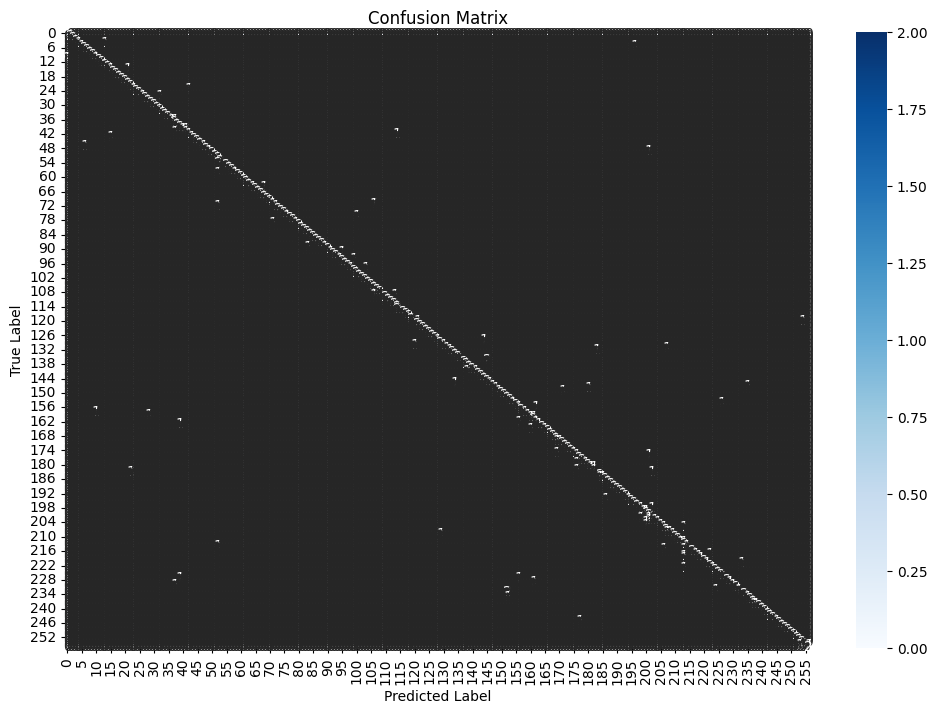

In [7]:
y_true = []
y_pred = []

test_gen.reset()
steps = int(np.ceil(test_gen.samples / test_gen.batch_size))

for _ in range(steps):
    x_batch, y_batch = next(test_gen)

    if y_batch.ndim > 1:
        y_true.extend(np.argmax(y_batch, axis=1))
    else:
        y_true.extend(y_batch)

    preds = model.predict(x_batch)
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", linewidths=0.5, linecolor='gray')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [8]:
report = classification_report(y_test, y_pred, output_dict=True)

precision_macro = report['macro avg']['precision']
recall_macro = report['macro avg']['recall']
f1_macro = report['macro avg']['f1-score']

precision_weighted = report['weighted avg']['precision']
recall_weighted = report['weighted avg']['recall']
f1_weighted = report['weighted avg']['f1-score']

print(f"\nMacro Avg - Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1 Score: {f1_macro:.4f}")
print(f"Weighted Avg - Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1 Score: {f1_weighted:.4f}")


Macro Avg - Precision: 0.8598, Recall: 0.8230, F1 Score: 0.8127
Weighted Avg - Precision: 0.8598, Recall: 0.8230, F1 Score: 0.8127


c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\LENOVO\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:

y_test_onehot = label_binarize(y_test, classes=np.arange(model.output_shape[-1]))
roc_auc = roc_auc_score(y_test_onehot, y_pred_probs, average='macro', multi_class='ovr')

print(f"ROC AUC Score (macro): {roc_auc:.4f}")

ROC AUC Score (macro): 0.9991
